In [1]:
!pip install --upgrade pandas
!pip install --upgrade pandas-datareader

In [2]:
import numpy as np
import pandas as pd
from matplotlib import style
import datetime
import pandas_datareader.data as web
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

In [3]:
# Get the stock data using yahoo API:
# get 2009-2019 data to train our model
train_data = web.DataReader('BBCA.JK', 'yahoo', datetime.datetime(2010,1,4),datetime.datetime(2019,12,1)) 

# get 2020 data to present date to test the SVM model
# test_data = web.DataReader('BBCA.JK', 'yahoo',  datetime.datetime(2020,1,2), datetime.date.today()) 
test_data = web.DataReader('BBCA.JK', 'yahoo',  datetime.datetime(2020,1,4), datetime.datetime(2021,12,1)) 

In [4]:
train_data

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2010-01-04,1010.0,965.0,1010.0,1010.0,77812500.0,855.341187
2010-01-05,1020.0,990.0,1020.0,1020.0,44442500.0,863.810059
2010-01-06,1020.0,990.0,990.0,990.0,27782500.0,838.403809
2010-01-07,995.0,965.0,995.0,995.0,38632500.0,842.638184
2010-01-08,995.0,970.0,970.0,970.0,27427500.0,821.466492
...,...,...,...,...,...,...
2019-11-26,6330.0,6270.0,6330.0,6285.0,192783500.0,6034.974609
2019-11-27,6300.0,6240.0,6270.0,6300.0,58833500.0,6049.377441
2019-11-28,6295.0,6245.0,6295.0,6250.0,44248000.0,6001.366699


In [5]:
test_data

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2020-01-06,6750.0,6690.0,6720.0,6735.0,27300000.0,6487.538574
2020-01-07,6770.0,6730.0,6735.0,6740.0,45022500.0,6492.354492
2020-01-08,6745.0,6670.0,6670.0,6680.0,53692500.0,6434.559570
2020-01-09,6755.0,6730.0,6740.0,6740.0,40363500.0,6492.354492
2020-01-10,6825.0,6710.0,6765.0,6725.0,73362000.0,6477.905762
...,...,...,...,...,...,...
2021-11-26,7450.0,7250.0,7400.0,7275.0,113288400.0,7275.000000
2021-11-29,7425.0,7175.0,7275.0,7400.0,87907900.0,7400.000000
2021-11-30,7425.0,7275.0,7325.0,7275.0,144923700.0,7275.000000


In [6]:
# sort by date
train_data = train_data.sort_values('Date')
test_data = test_data.sort_values('Date')

# fix the date 
train_data.reset_index(inplace=True)
train_data.set_index("Date", inplace=True)
test_data.reset_index(inplace=True)
test_data.set_index("Date", inplace=True)

In [7]:
train_data

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2010-01-04,1010.0,965.0,1010.0,1010.0,77812500.0,855.341187
2010-01-05,1020.0,990.0,1020.0,1020.0,44442500.0,863.810059
2010-01-06,1020.0,990.0,990.0,990.0,27782500.0,838.403809
2010-01-07,995.0,965.0,995.0,995.0,38632500.0,842.638184
2010-01-08,995.0,970.0,970.0,970.0,27427500.0,821.466492
...,...,...,...,...,...,...
2019-11-26,6330.0,6270.0,6330.0,6285.0,192783500.0,6034.974609
2019-11-27,6300.0,6240.0,6270.0,6300.0,58833500.0,6049.377441
2019-11-28,6295.0,6245.0,6295.0,6250.0,44248000.0,6001.366699


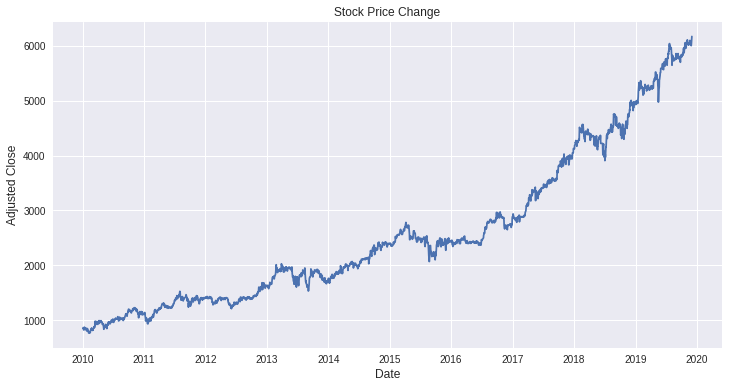

In [8]:
from matplotlib import pyplot as plt

style.use('seaborn')
plt.figure(figsize = (12,6))
plt.plot(train_data["Adj Close"])
plt.title("Stock Price Change")
plt.xlabel("Date", fontsize = 12)
plt.ylabel("Adjusted Close", fontsize = 12)
plt.show()

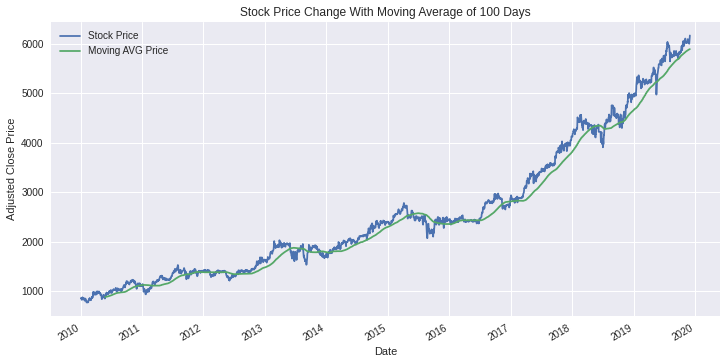

In [9]:
# Rolling mean
close_price = train_data['Adj Close']
moving_avg = close_price.rolling(window=100).mean()

plt.figure(figsize = (12,6))
plt.title("Stock Price Change With Moving Average of 100 Days")
close_price.plot(label='Stock Price')
moving_avg.plot(label='Moving AVG Price')
plt.xlabel('Date')
plt.ylabel('Adjusted Close Price')
plt.legend()

In [10]:
import matplotlib.dates as mdates

# change the dates into ints for training 
indxed_dates = train_data.copy()
indxed_dates = indxed_dates.reset_index()

# Store the original dates for plotting the predicitons
actual_dates = indxed_dates['Date']

# convert to ints
indxed_dates['Date'] = indxed_dates['Date'].map(mdates.date2num)

indxed_dates

,Date,High,Low,Open,Close,Volume,Adj Close
0,733776.0,1010.0,965.0,1010.0,1010.0,77812500.0,855.341187
1,733777.0,1020.0,990.0,1020.0,1020.0,44442500.0,863.810059
2,733778.0,1020.0,990.0,990.0,990.0,27782500.0,838.403809
3,733779.0,995.0,965.0,995.0,995.0,38632500.0,842.638184
4,733780.0,995.0,970.0,970.0,970.0,27427500.0,821.466492
...,...,...,...,...,...,...,...
2467,737389.0,6330.0,6270.0,6330.0,6285.0,192783500.0,6034.974609
2468,737390.0,6300.0,6240.0,6270.0,6300.0,58833500.0,6049.377441
2469,737391.0,6295.0,6245.0,6295.0,6250.0,44248000.0,6001.366699
2470,737392.0,6295.0,6225.0,6230.0,6280.0,52954500.0,6030.173340


In [11]:
# Use sklearn support vector regression to predicit our data:
from sklearn.svm import SVR

dates_data = indxed_dates['Date'].to_numpy()
prices_data = train_data['Adj Close'].to_numpy()

#Convert to 1d Vector
dates_data = np.reshape(dates_data, (len(dates_data), 1))
prices_data = np.reshape(prices_data, (len(prices_data), 1))

In [12]:
SVR_linear = make_pipeline(StandardScaler(), SVR(kernel='linear', C=1))
SVR_linear.fit(dates_data, prices_data)
SVR_linear_train = SVR_linear.predict(dates_data)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [13]:
SVR_linear_train

array([ 824.88597658,  825.72244712,  826.55891767, ..., 3848.72700001,
       3849.56347056, 3852.0728822 ])

In [14]:
SVR_rbfk = SVR(kernel= 'rbf', C= 1e3, gamma= 0.1)
SVR_rbfk.fit(dates_data, prices_data)
SVR_rbfk_train = SVR_rbfk.predict(dates_data)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [15]:
SVR_rbfk_train

array([1002.15068922,  863.90975354,  838.30380007, ..., 5911.47745575,
       5592.15294021, 4232.57409558])

In [16]:
SVR_poly = make_pipeline(StandardScaler(), SVR(kernel='poly', C=1e3, degree=3, epsilon=0.1, coef0=1))
SVR_poly.fit(dates_data, prices_data)
SVR_poly_train = SVR_poly.predict(dates_data)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [17]:
SVR_poly_train

array([ 785.67417511,  786.87089419,  788.06640839, ..., 6196.41173039,
       6200.68864694, 6213.53686198])

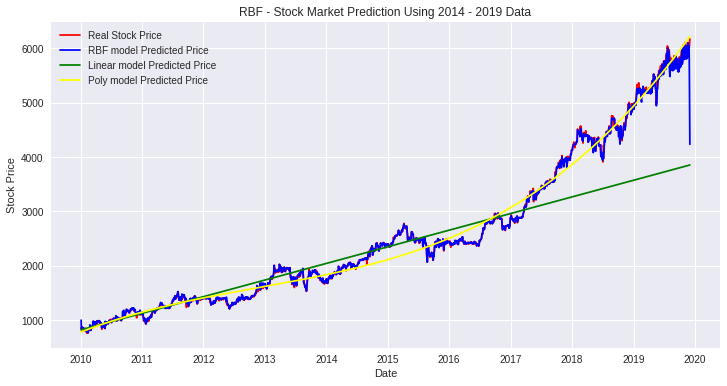

In [18]:
plt.figure(figsize = (12,6))
plt.title('RBF - Stock Market Prediction Using 2014 - 2019 Data')
plt.plot(dates_data, prices_data, color= 'red', label= 'Real Stock Price')
plt.plot(actual_dates, SVR_rbfk_train, color= 'blue', label= 'RBF model Predicted Price') 
plt.plot(actual_dates, SVR_linear_train, color= 'green', label= 'Linear model Predicted Price') 
plt.plot(actual_dates, SVR_poly_train, color= 'yellow', label= 'Poly model Predicted Price') 
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

In [19]:
# change the dates into ints for training 
test_indxed_dates = test_data.copy()
test_indxed_dates = test_indxed_dates.reset_index()

# Store the original dates for plotting the predicitons
test_actual_dates = test_indxed_dates['Date']

# convert to ints
test_indxed_dates['Date'] = test_indxed_dates['Date'].map(mdates.date2num)

In [20]:
test_indxed_dates

,Date,High,Low,Open,Close,Volume,Adj Close
0,737430.0,6750.0,6690.0,6720.0,6735.0,27300000.0,6487.538574
1,737431.0,6770.0,6730.0,6735.0,6740.0,45022500.0,6492.354492
2,737432.0,6745.0,6670.0,6670.0,6680.0,53692500.0,6434.559570
3,737433.0,6755.0,6730.0,6740.0,6740.0,40363500.0,6492.354492
4,737434.0,6825.0,6710.0,6765.0,6725.0,73362000.0,6477.905762
...,...,...,...,...,...,...,...
462,738120.0,7450.0,7250.0,7400.0,7275.0,113288400.0,7275.000000
463,738123.0,7425.0,7175.0,7275.0,7400.0,87907900.0,7400.000000
464,738124.0,7425.0,7275.0,7325.0,7275.0,144923700.0,7275.000000
465,738125.0,7450.0,7275.0,7275.0,7300.0,76538100.0,7300.000000


In [21]:
test_dates_data = test_indxed_dates['Date'].to_numpy()
test_prices_data = test_data['Adj Close'].to_numpy()

#Convert to 1d Vector
test_dates_data = np.reshape(test_dates_data, (len(test_dates_data), 1))
test_prices_data = np.reshape(test_prices_data, (len(test_prices_data), 1))

In [22]:
SVR_rbfk = SVR(kernel= 'rbf', C= 1e3, gamma= 0.1)
SVR_rbfk.fit(test_dates_data, test_prices_data)
SVR_rbfk_test = SVR_rbfk.predict(test_dates_data)
SVR_rbfk_test

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([6487.43861547, 6492.25424462, 6492.74885545, 6492.25450373,
       6478.00552807, 6497.27131469, 6549.05458339, 6583.76465267,
       6604.25491045, 6622.29475986, 6583.76451135, 6579.14813218,
       6588.57977685, 6583.18092489, 6559.88258408, 6588.57991509,
       6589.56844823, 6535.60204807, 6410.71632097, 6242.00813201,
       6203.47729977, 6357.39815391, 6468.14492351, 6508.87931612,
       6511.52019015, 6535.60129997, 6554.37736654, 6550.04984689,
       6501.99325776, 6437.18403578, 6472.98927395, 6467.19760192,
       6429.72201358, 6393.94905478, 6371.84737294, 6285.35423538,
       6237.72639816, 6184.21216209, 6128.19669954, 6058.78884496,
       5950.83882054, 6087.68647538, 6203.27727281, 6166.17470338,
       5972.29589696, 5682.98208704, 5707.20069342, 5617.26543622,
       5451.75236104, 5355.81040573, 5355.61037154, 5099.00517323,
       4816.38692469, 4641.08363828, 4560.92337712, 4275.50703432,
       4412.20858757, 5085.89887076, 5307.64879673, 5346.98813

In [23]:
SVR_linear = make_pipeline(StandardScaler(), SVR(kernel='linear', C=1))
SVR_linear.fit(test_dates_data, test_prices_data)
SVR_linear_test =  SVR_linear.predict(test_dates_data)
SVR_linear_test

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([6051.0550222 , 6051.69943621, 6052.34385022, 6052.98826424,
       6053.63267825, 6055.56592029, 6056.2103343 , 6056.85474832,
       6057.49916233, 6058.14357634, 6060.07681838, 6060.7212324 ,
       6061.36564641, 6062.01006042, 6062.65447444, 6064.58771648,
       6065.23213049, 6065.8765445 , 6066.52095852, 6067.16537253,
       6069.09861457, 6069.74302858, 6070.3874426 , 6071.03185661,
       6071.67627062, 6073.60951266, 6074.25392668, 6074.89834069,
       6075.5427547 , 6076.18716872, 6078.12041076, 6078.76482477,
       6079.40923878, 6080.0536528 , 6080.69806681, 6082.63130885,
       6083.27572286, 6083.92013688, 6084.56455089, 6085.2089649 ,
       6087.14220694, 6087.78662096, 6088.43103497, 6089.07544898,
       6089.719863  , 6091.65310504, 6092.29751905, 6092.94193306,
       6093.58634708, 6094.23076109, 6096.16400313, 6096.80841714,
       6097.45283116, 6098.09724517, 6098.74165918, 6100.67490122,
       6101.31931524, 6102.60814326, 6103.25255728, 6105.18579

In [24]:
SVR_poly = make_pipeline(StandardScaler(), SVR(kernel='poly', C=1e3, degree=4, epsilon=0.1, coef0=1))
SVR_poly.fit(test_dates_data, test_prices_data)
SVR_poly_test = SVR_poly.predict(test_dates_data)
SVR_poly_test

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([7012.71184485, 6979.36956957, 6946.45658058, 6913.97006797,
       6881.90722985, 6788.23286389, 6757.83686528, 6727.85065204,
       6698.27147039, 6669.0965746 , 6583.97026519, 6556.38521576,
       6529.19084375, 6502.38445155, 6475.96334954, 6398.98500896,
       6374.07833209, 6349.5436177 , 6325.3782243 , 6301.57951842,
       6232.35731159, 6209.99918157, 6187.99469205, 6166.34125769,
       6145.03630116, 6083.18664566, 6063.24998763, 6043.64904113,
       6024.38127693, 6005.44417386, 5950.5917399 , 5932.95222991,
       5915.63089544, 5898.62526341, 5881.93286879, 5833.71057924,
       5818.24664421, 5803.08374167, 5788.2194547 , 5773.6513744 ,
       5731.70040476, 5718.29322249, 5705.17032268, 5692.32934454,
       5679.7679353 , 5643.73771373, 5632.27121291, 5621.07263749,
       5610.13968283, 5599.4700523 , 5569.01825961, 5559.3791198 ,
       5549.99194132, 5540.85447567, 5531.96448236, 5506.75705199,
       5498.83470365, 5483.69698532, 5476.47723863, 5456.18835

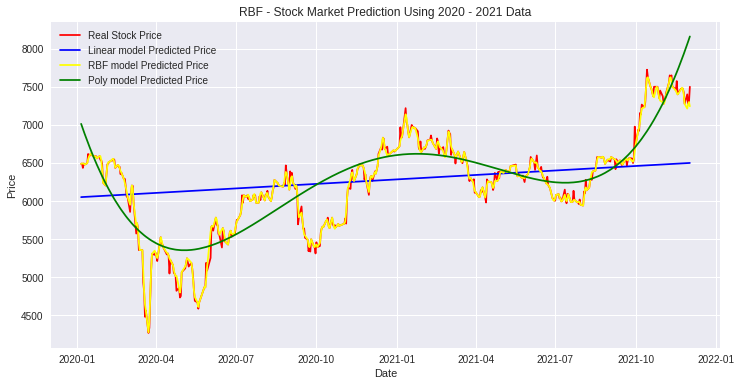

In [25]:
plt.figure(figsize = (12,6))
plt.title('RBF - Stock Market Prediction Using 2020 - 2021 Data')
plt.plot(test_dates_data, test_prices_data, color= 'red', label= 'Real Stock Price')
plt.plot(test_actual_dates, SVR_linear_test, color= 'blue', label= 'Linear model Predicted Price')
plt.plot(test_actual_dates, SVR_rbfk_test, color= 'yellow', label= 'RBF model Predicted Price')
plt.plot(test_actual_dates, SVR_poly_test, color= 'green', label= 'Poly model Predicted Price') 
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

In [26]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

print("SVR RBF Train RMSE: %.2f"
      % np.sqrt(mean_squared_error(prices_data, SVR_rbfk_train)))

print("SVR RBF Train R2 Score: %.2f"
      % r2_score(prices_data, SVR_rbfk_train))

print("SVR RBF Train MAE Score: %.2f"
      % mean_absolute_error(prices_data, SVR_rbfk_train))

print("SVR RBF Test RMSE: %.2f"
      % np.sqrt(mean_squared_error(test_prices_data, SVR_rbfk_test)))

print("SVR RBF Test R2 Score: %.2f"
      % r2_score(test_prices_data, SVR_rbfk_test))

print("SVR RBF Test MAE Score: %.2f"
      % mean_absolute_error(test_prices_data, SVR_rbfk_test))


SVR RBF Train RMSE: 53.71
SVR RBF Train R2 Score: 1.00
SVR RBF Train MAE Score: 14.36
SVR RBF Test RMSE: 54.45
SVR RBF Test R2 Score: 0.99
SVR RBF Test MAE Score: 25.97


In [27]:
print("SVR Linear Train RMSE: %.2f"
      % np.sqrt(mean_squared_error(prices_data, SVR_linear_train)))

print("SVR Linear Train R2 Score: %.2f"
      % r2_score(prices_data, SVR_linear_train))

print("SVR Linear Train MAE Score: %.2f"
      % mean_absolute_error(prices_data, SVR_linear_train))

print("SVR Linear Test RMSE: %.2f"
      % np.sqrt(mean_squared_error(test_prices_data, SVR_linear_test)))

print("SVR Linear Test R2 Score: %.2f"
      % r2_score(test_prices_data, SVR_linear_test))

print("SVR Linear Test MAE Score: %.2f"
      % mean_absolute_error(test_prices_data, SVR_linear_test))

SVR Linear Train RMSE: 703.80
SVR Linear Train R2 Score: 0.75
SVR Linear Train MAE Score: 419.18
SVR Linear Test RMSE: 572.66
SVR Linear Test R2 Score: 0.21
SVR Linear Test MAE Score: 442.54


In [28]:
print("SVR Poly Train RMSE: %.2f"
      % np.sqrt(mean_squared_error(prices_data, SVR_poly_train)))

print("SVR Poly Train R2 Score: %.2f"
      % r2_score(prices_data, SVR_poly_train))

print("SVR Poly Train MAE Score: %.2f"
      % mean_absolute_error(prices_data, SVR_poly_train))

print("SVR Poly Test RMSE: %.2f"
      % np.sqrt(mean_squared_error(test_prices_data, SVR_poly_test)))

print("SVR Poly Test R2 Score: %.2f"
      % r2_score(test_prices_data, SVR_poly_test))

print("SVR Poly Test MAE Score: %.2f"
      % mean_absolute_error(test_prices_data, SVR_poly_test))

SVR Poly Train RMSE: 172.68
SVR Poly Train R2 Score: 0.99
SVR Poly Train MAE Score: 130.61
SVR Poly Test RMSE: 339.75
SVR Poly Test R2 Score: 0.72
SVR Poly Test MAE Score: 261.88
